In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from v1dd_public import ARTIFACT_DIR
import seaborn as sns

In [2]:
mouse_colors = {'slc2': "#66CCEE", 'slc4': "#228833", 'slc5': '#CCBB44', 'teto1': '#EE6677'}
mice = ['slc2', 'slc4', 'slc5', 'teto1']
mouse_ids = ["M409828", "M416296", "M427836", "M438833"]
z_groups_high_to_low = [[575, 600, 625], [650, 675, 700, 725], [500, 525, 550], [482, 498, 514], [434, 450, 466], \
    [386, 402, 418], [338, 354, 370], [290, 306, 322], [242, 258, 274], [194, 210, 226], [146, 162, 178], [98, 114, 130], [50, 66, 82]]
z_groups_low_to_high = [[50, 66, 82], [98, 114, 130], [146, 162, 178], [194, 210, 226], [242, 258, 274], [290, 306, 322], [338, 354, 370], \
    [386, 402, 418], [434, 450, 466], [482, 498, 514], [500, 525, 550], [575, 600, 625], [650, 675, 700, 725]]

z_groups_high_to_low = [[50], [66], [82], [98], [114], [130], [146], [162], [178], [194], [210], [226], \
    [242], [258], [274], [290], [306], [322], [338], [354], [370], [386], [402], [418], \
    [434], [450], [466], [482], [498], [514], [500], [525], [550], [575], [600], [625], \
    [650], [675], [700], [725]]
z_groups_low_to_high = [[50], [66], [82], [98], [114], [130], [146], [162], [178], [194], [210], [226], \
    [242], [258], [274], [290], [306], [322], [338], [354], [370], [386], [402], [418], \
    [434], [450], [466], [482], [498], [514], [500], [525], [550], [575], [600], [625], \
    [650, 675, 700, 725]]

stim_types = [
    "drifting_gratings_full", 
    "drifting_gratings_windowed", 
    "natural_images_12", 
    "natural_images"
    ]
decode_dims = {
    "drifting_gratings_full": "direction",
    "drifting_gratings_windowed": "direction",
    "natural_images_12": "image_index",
    "natural_images": "image_index"
               }

repetitions = 1000

chance = {
    "drifting_gratings_full_direction": 1/12, 
    "drifting_gratings_full_spatial": 1/2, 
    "drifting_gratings_full_direction_spatial": 1/24, 
    "drifting_gratings_windowed_direction": 1/12, 
    "drifting_gratings_windowed_spatial": 1/2, 
    "drifting_gratings_windowed_direction_spatial": 1/24, 
    "natural_images_12_image_index": 1/12,
    "natural_images_image_index": 1/118}

depth_mapping = {
    66: [50, 66, 82],
    114: [98, 114, 130], 
    162: [146, 162, 178],
    210: [194, 210, 226],
    258: [242, 258, 274],
    306: [290, 306, 322],
    354: [338, 354, 370],
    402: [386, 402, 418],
    450: [434, 450, 466],
    498: [482, 498, 514]
}

depths = [66,
    114, 
    162,
    210,
    258,
    306,
    354,
    402,
    450,
    498]

all_depths = [
    50, 66, 82,
    98, 114, 130,
    146, 162, 178,
    194, 210, 226,
    242, 258, 274,
    290, 306, 322,
    338, 354, 370,
    386, 402, 418,
    434, 450, 466,
    482, 498, 514,
    500, 525, 550, 575, 600, 625, 650, 675, 700, 725
]

In [3]:
def depth_volume_mapping(a, b):
    depth_values = {
        1: {1: 66, 4: 114},
        2: {1: 162, 4: 210},
        3: {1: 258, 4: 306},
        4: {1: 354, 4: 402},
        5: {1: 450, 4: 498},
    }

    return depth_values[a][b[1]]

def depth_volume_mapping_2(volume_id, plane):
    depth_values = {
            1: [50, 66, 82, 98, 114, 130],
            2: [146, 162, 178, 194, 210, 226],
            3: [242, 258, 274, 290, 306, 322],
            4: [338, 354, 370, 386, 402, 418],
            5: [434, 450, 466, 482, 498, 514],
            6: [500],
            7: [525],
            8: [550],
            9: [575],
            'a': [600],
            'b': [625],
            'c': [650],
            'd': [675],
            'e': [700],
            'f': [725]
        }
    
    return depth_values[volume_id][plane - 1]

### First decoding results: no bootstrapping, all experiments (min # of neurons threshold = 1)

In [4]:
# Load decoding results -- iterate through each stimulus type and decode dimension
decoding_dir = '/home/naomi/Desktop/data/decoding_results'
tag = "2025_0721_1"
all_results_df = pd.DataFrame()
for stim_type in stim_types:
    decode_dim = decode_dims[stim_type]
    path_name = os.path.join(decoding_dir, f'{tag}_{stim_type}_{decode_dim}_Boot1_Rep1')
    results_df = pd.DataFrame()
    for filename in os.listdir(path_name):
        f = os.path.join(path_name, filename)
        results_df = pd.concat([results_df, pd.read_pickle(f)])
    
    results_df['stim_type'] = stim_type
    results_df['decode_dim'] = decode_dim

    all_results_df = pd.concat([all_results_df, results_df], axis=0)

all_results_df['depth'] = all_results_df.apply(lambda x: depth_volume_mapping_2(volume_id = x['volume_id'], plane = x['plane']), axis=1)

In [5]:
# Organize data into a 5D array
# Dimensions: (stim_type, mouse_id, column_id, depth, 5 folds)

mouse_ids_mod = [409828, 416296, 427836, 438833]
column_ids = [1, 2, 3, 4, 5]

n_depths = len(all_depths)
n_mice = len(mouse_ids_mod)
n_columns = len(column_ids)
n_stims = len(stim_types)
data = np.zeros((n_stims, n_mice, n_columns, n_depths, 5))
shuf_data = np.zeros((n_stims, n_mice, n_columns, n_depths, 5))

for stim_idx, stim_type in enumerate(stim_types):
    decode_dim = decode_dims[stim_type]
    print(f"Processing {stim_type} with decode_dim {decode_dim}")
    for mouse_idx, mouse_id in enumerate(mouse_ids_mod):
        for column_idx, column_id in enumerate(column_ids):
            for depth_idx, depth in enumerate(all_depths):
                    test_accuracies = all_results_df[
                        (all_results_df['mouse_id'] == mouse_id) & 
                        (all_results_df['depth'] == depth) &
                        (all_results_df['stim_type'] == stim_type) &
                        (all_results_df['decode_dim'] == decode_dim) & 
                        (all_results_df['column_id'] == column_id)
                        ].test_accuracies       # Note, this includes 5 folds
                        
                    if len(test_accuracies) > 0:
                        data[stim_idx, mouse_idx, column_idx, depth_idx, :] = test_accuracies.values[0]
                    else:
                        # print(f"Missing data for {stim_type}, {decode_dim}, {mouse_id}, {column_id}, {depth}")
                        data[stim_idx, mouse_idx, column_idx, depth_idx, :] = np.nan
                        continue
                        
                    shuf_test_accuracies = all_results_df[
                        (all_results_df['mouse_id'] == mouse_id) & 
                        (all_results_df['depth'] == depth) &
                        (all_results_df['stim_type'] == stim_type) &
                        (all_results_df['decode_dim'] == decode_dim) & 
                        (all_results_df['column_id'] == column_id)
                    ].shuf_test_accuracies

                    if len(shuf_test_accuracies) > 0:
                        shuf_data[stim_idx, mouse_idx, column_idx, depth_idx, :] = shuf_test_accuracies.values[0]
                    else:
                        # print(f"Missing shuffled data for {stim_type}, {decode_dim}, {mouse_id}, {column_id}, {depth}")
                        shuf_data[stim_idx, mouse_idx, column_idx, depth_idx, :] = np.nan
                        continue
                

    data[stim_idx, :, :, :, :] /= chance[f"{stim_type}_{decode_dim}"]
    shuf_data[stim_idx, :, :, :, :] /= chance[f"{stim_type}_{decode_dim}"]

Processing drifting_gratings_full with decode_dim direction
Processing drifting_gratings_windowed with decode_dim direction
Processing natural_images_12 with decode_dim image_index
Processing natural_images with decode_dim image_index


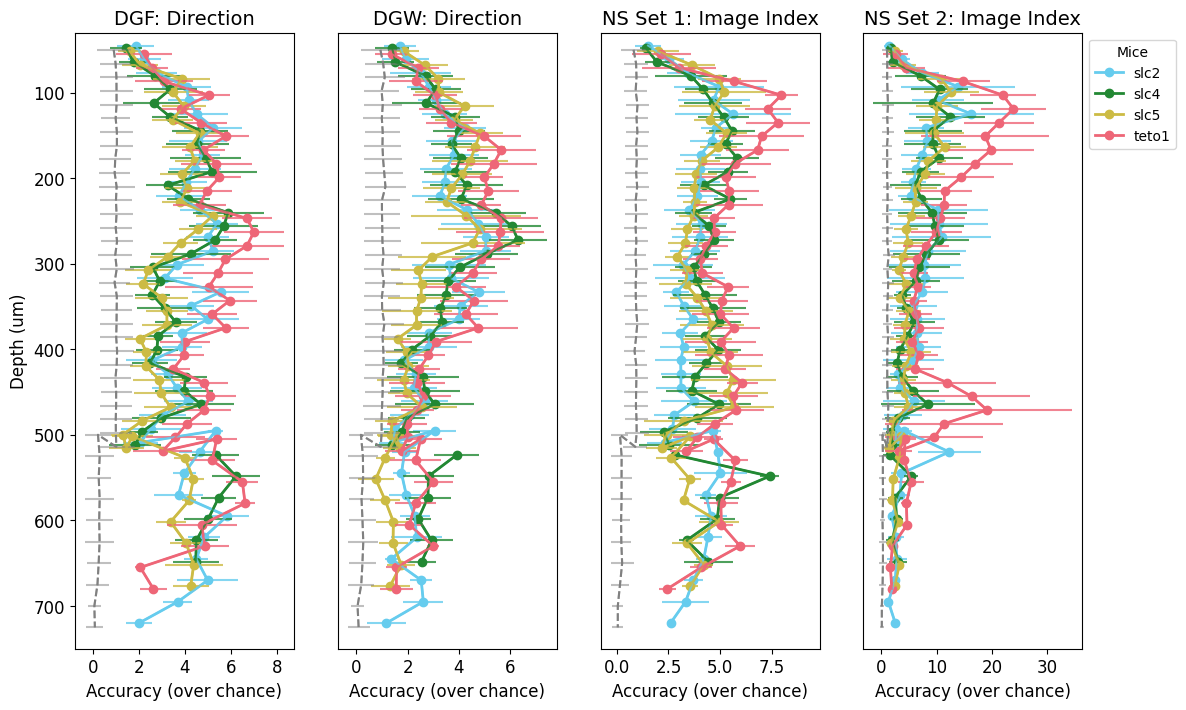

In [6]:
# Plot the results as a lineplot 

# Add some jitter to visualize the individual mice
jitter_amount = 5
jitter_step = jitter_amount * 2 / (n_mice - 1)
jitter_values = np.linspace(-jitter_amount, jitter_amount, n_mice)
fixed_jitters = np.tile(jitter_values, (n_depths, 1))

titles = [
    'DGF: Direction',
    'DGW: Direction',
    'NS Set 1: Image Index',
    'NS Set 2: Image Index'
]

fig = plt.figure(figsize=(13, 8))


for stim_idx, stim_type in enumerate(stim_types):
    ax = plt.subplot(1, n_stims, stim_idx + 1)

    # Plot data
    for mouse_idx, mouse_id in enumerate(mice):
        mouse_color = mouse_colors[mouse_id]

        # Plot data
        means, std_errors = [], []
        
        for depth_idx, depth in enumerate(all_depths):
            data_values = data[stim_idx, mouse_idx, :, depth_idx, :]
            if np.all(np.isnan(data_values)):
                means.append(np.nan), std_errors.append(np.nan)
                continue

            mean = np.nanmean(data_values)
            std_error = np.nanstd(data_values)
            means.append(mean), std_errors.append(std_error)
        
        plt.errorbar(means, all_depths + fixed_jitters[:, mouse_idx], xerr=std_errors, fmt='-', color=mouse_color, label=mouse_id, capsize=0, alpha=0.8)
        plt.plot(means, all_depths + fixed_jitters[:, mouse_idx], 'o-', color=mouse_color, linewidth=2)
    

    # Plot shuffled data (average over mice for visualization, so just need to iterate over depths)
    shuf_means, shuf_std_errors = [], []
    for depth_idx, depth in enumerate(all_depths):
        shuf_data_values = shuf_data[stim_idx, :, :, depth_idx, :]
        if np.all(np.isnan(shuf_data_values)):
            shuf_means.append(np.nan), shuf_std_errors.append(np.nan)
            continue
        shuf_mean = np.nanmean(shuf_data_values)
        shuf_std_error = np.nanstd(shuf_data_values)
        shuf_means.append(shuf_mean), shuf_std_errors.append(shuf_std_error)

    plt.errorbar(shuf_means, all_depths, xerr=shuf_std_errors, fmt='--', color='grey', label='Shuffled', capsize=0, alpha=0.5)
    plt.plot(shuf_means, all_depths, '--', color='grey', linewidth=1.5)

    if stim_idx == 0:
        plt.yticks(fontsize=12)
        plt.ylabel('Depth (um)', fontsize=12)
    elif stim_idx == n_stims - 1:
        plt.legend(mice, loc='upper left', bbox_to_anchor=(1, 1), title='Mice')
        plt.yticks([])
    else:
        plt.yticks([])

    ax.set_ylim(30, 750)
    ax.set_title(titles[stim_idx], fontsize=14)
    ax.set_xlabel('Accuracy (over chance)', fontsize=12)
    plt.xticks(fontsize=12)
    plt.gca().invert_yaxis()

In [7]:
shuf_means

[1.0000709219858155,
 1.056427445682765,
 1.0250112574580659,
 1.0940206011482605,
 1.1813283800517842,
 1.0500512214342004,
 1.1815608465608465,
 1.018668242710796,
 1.043874254193403,
 1.019000337723742,
 1.09408702015085,
 1.1126843408758302,
 1.0377304964539007,
 1.093754925137904,
 1.0624383654170888,
 1.3063289429246876,
 1.0753236519193965,
 1.218689069008218,
 1.1376246763480804,
 1.0498187549251379,
 1.0622723179106157,
 1.2065343915343916,
 1.056493864685354,
 1.0373319824383653,
 1.0562946076775863,
 1.0878436339074637,
 1.2374856467409658,
 1.1688748170663064,
 1.1688748170663064,
 1.0562281886749973,
 0.20002082629742204,
 0.26893054148373297,
 0.2561116739840144,
 0.29370482944951026,
 0.19384385905662502,
 0.27510750872453,
 0.27497467071935155,
 0.21254080828548916,
 0.07498705392322413,
 0.0687104581785433]